In [1]:
#!pip install bitstring

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import bitstring as bs

In [3]:
filename = 'foreman_qcif.yuv'
width = 176
height = 144

In [4]:
def read_yuv(filename, width=176, height=144):
    file = open(filename, 'rb')

    frames = []
    while True:
        frame = read_frame(file)
        if frame is None:
            break
        y, u, v = frame
        u = resize_uv(u)
        v = resize_uv(v)
        array = np.dstack((y, u, v))
        rgb_array = ycbcr_to_rgb(array)
        frames.append(rgb_array)
    file.close()
    return np.array(frames)

def read_frame(file, width=176, height=144):
    Y = read_y(file, width, height)
    UV = read_uv(file, width, height)
    if Y is None or UV is None:
        return None
    return (Y, UV[0], UV[1])
    
def read_y(file, width=176, height=144):
    y_size = width * height
    y_bytes = file.read(y_size)
    if not y_bytes:
        return None
    y_array = yuv_bytelist_to_array(list(y_bytes), width, height)
    return y_array

def read_uv(file, width=176, height=144):
    uv_size = width * height // 4
    u_bytes = file.read(uv_size)
    if not u_bytes:
        return None
    v_bytes = file.read(uv_size)
    if not v_bytes:
        return None
    u_array = yuv_bytelist_to_array(list(u_bytes), width//2, height//2)
    v_array = yuv_bytelist_to_array(list(v_bytes), width//2, height//2)
    return u_array, v_array
    
def yuv_bytelist_to_array(bytelist, width, height):
    return np.array(bytelist, dtype=np.uint8).reshape(height, width)

def resize_uv(array):
    return np.kron(array, np.ones((2, 2))).astype(np.uint8)

# source: https://stackoverflow.com/a/34913974
def rgb_to_ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr_to_rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [5]:
frames = read_yuv(filename)
#frames

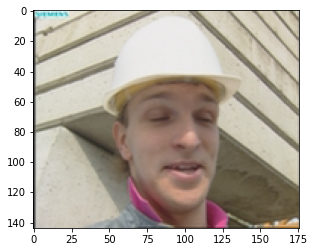

In [6]:
plt.imshow(frames[1])

In [7]:
 #for frame in frames: 
  #cv2_imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
   
    # Press Q on keyboard to  exit
  #if cv2.waitKey(25) & 0xFF == ord('q'):
    #break

In [8]:
frame = frames[1]
frame.shape

(144, 176, 3)

In [9]:
def get_blocks(mat: np.ndarray, block_size: int) -> tuple:
    '''
    Break a matrix into square blocks of the specified size
    For best results, the size of the matrix should be a
    multiple of block_size
    '''
    blocks_per_column = mat.shape[0] // block_size
    blocks_per_row = mat.shape[1] // block_size
    blocks = []
    for i in range(blocks_per_column):
        start1 = i * block_size
        end1 = (i + 1) * block_size
        for j in range(blocks_per_row):
            start2 = j * block_size
            end2 = (j + 1) * block_size
            block = mat[start1:end1, start2:end2,:]
            blocks.append((block, (i * block_size, j * block_size)))
    return blocks

In [10]:
#locks_per_row, blocks_per_column

In [11]:
def blocks_to_frame(blocks, height, width):
    blocks_size = blocks[0][0].shape[0]
    blocks_per_column = height // block_size
    blocks_per_row = width // block_size
    img = np.zeros((height, width, 3), dtype=np.uint8)
    for (block, coords) in blocks:
        p = coords[0]
        q = coords[1]
        for i in range(block_size):
            for j in range(block_size):
                img[p+i,q+j] = block[i,j]
    return img

(0, 0)


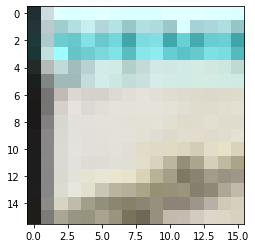

(0, 16)


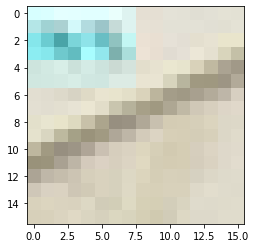

(0, 32)


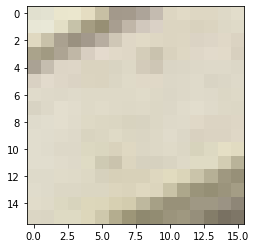

(0, 48)


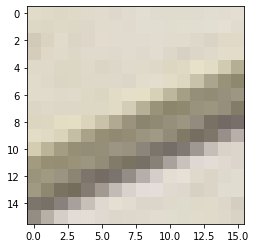

(0, 64)


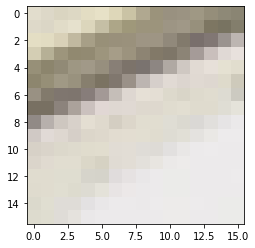

(0, 80)


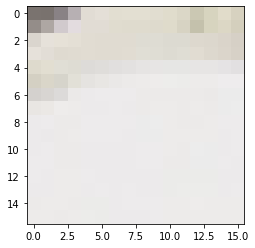

(0, 96)


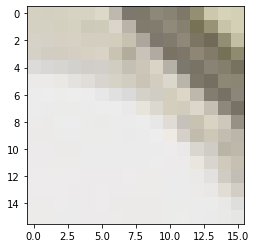

(0, 112)


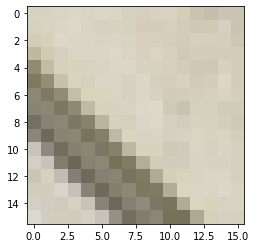

(0, 128)


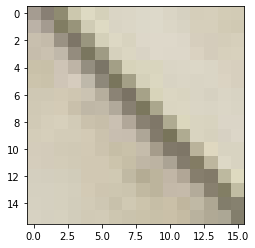

(0, 144)


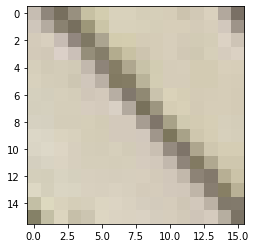

(0, 160)


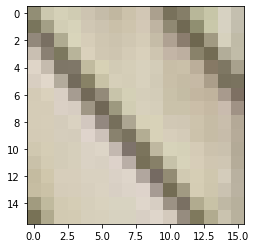

(16, 0)


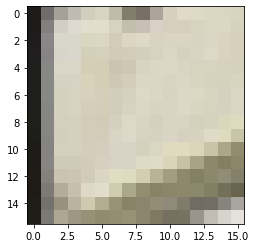

(16, 16)


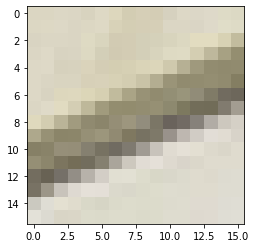

(16, 32)


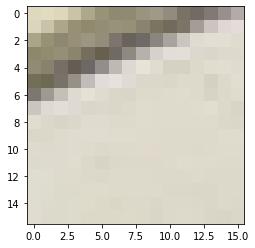

(16, 48)


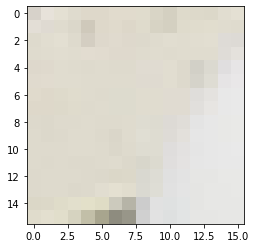

(16, 64)


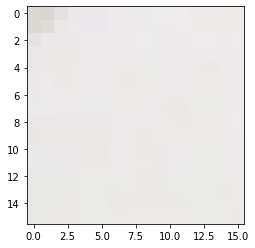

(16, 80)


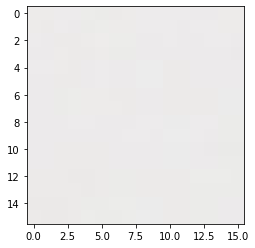

(16, 96)


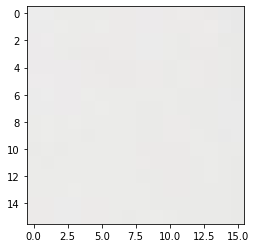

(16, 112)


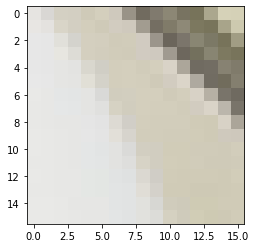

(16, 128)


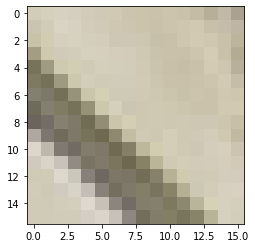

(16, 144)


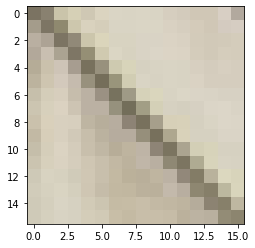

(16, 160)


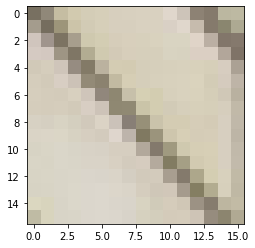

(32, 0)


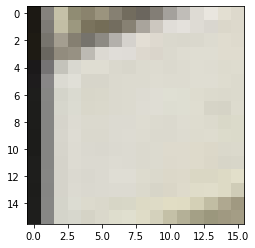

(32, 16)


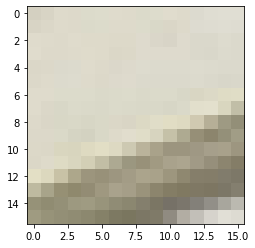

(32, 32)


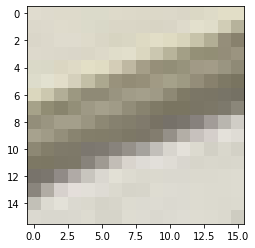

(32, 48)


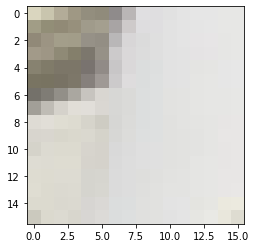

(32, 64)


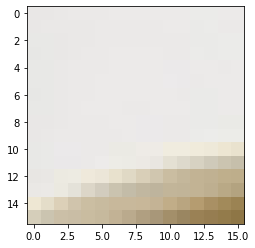

(32, 80)


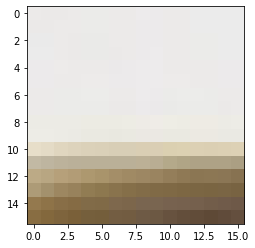

(32, 96)


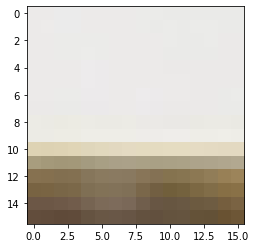

(32, 112)


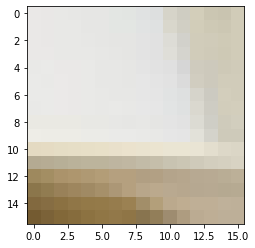

(32, 128)


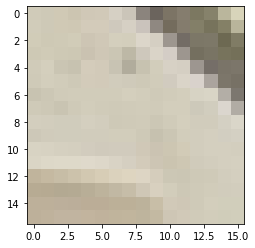

(32, 144)


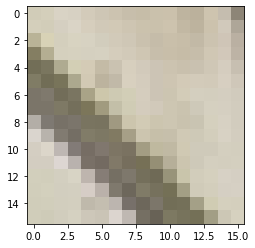

(32, 160)


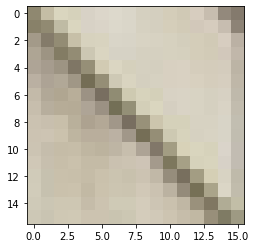

(48, 0)


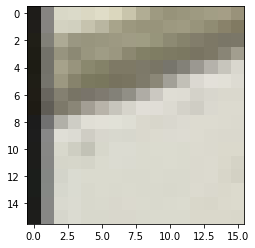

(48, 16)


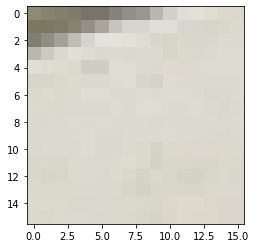

(48, 32)


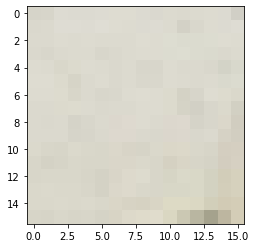

(48, 48)


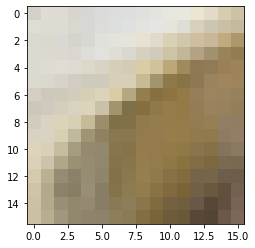

(48, 64)


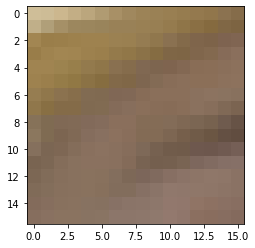

(48, 80)


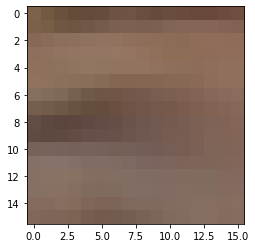

(48, 96)


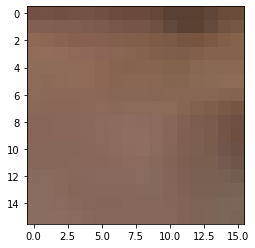

(48, 112)


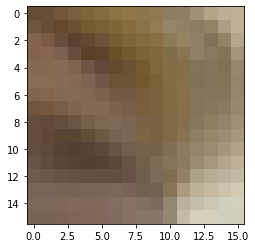

(48, 128)


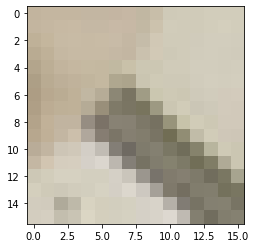

(48, 144)


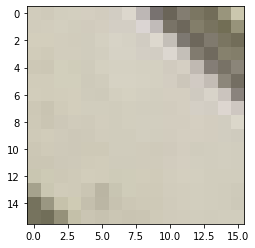

(48, 160)


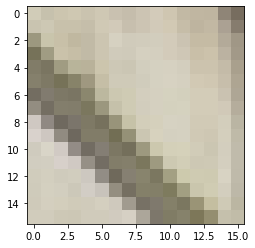

(64, 0)


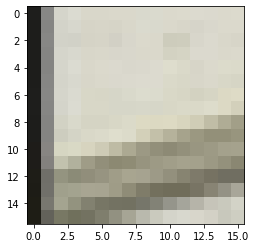

(64, 16)


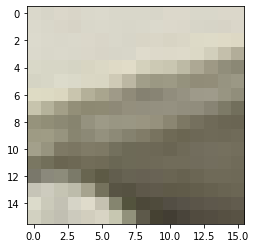

(64, 32)


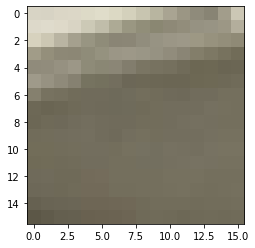

(64, 48)


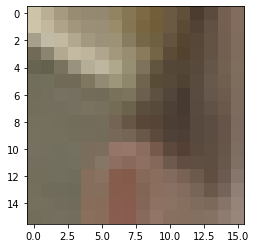

(64, 64)


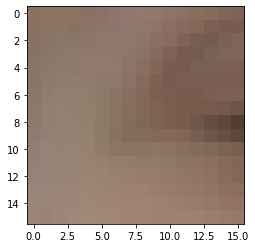

(64, 80)


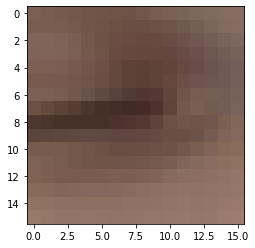

(64, 96)


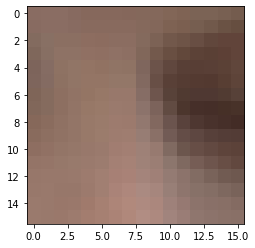

(64, 112)


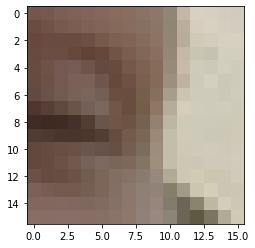

(64, 128)


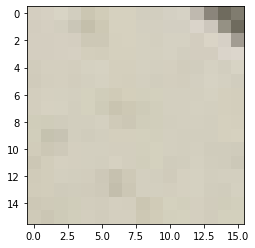

(64, 144)


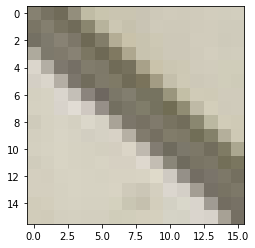

(64, 160)


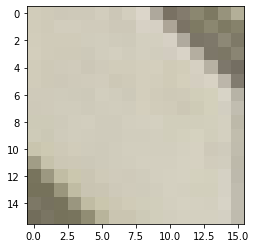

(80, 0)


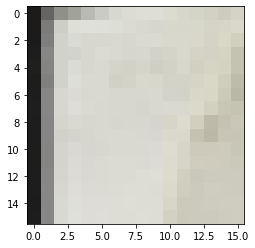

(80, 16)


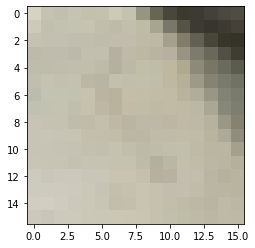

(80, 32)


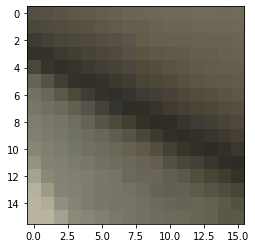

(80, 48)


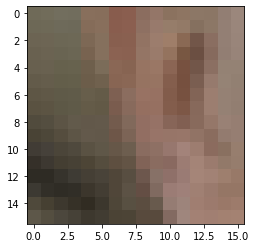

(80, 64)


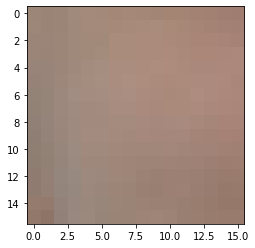

(80, 80)


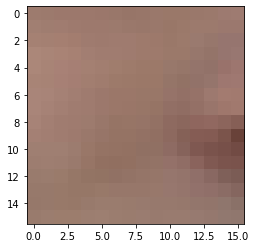

(80, 96)


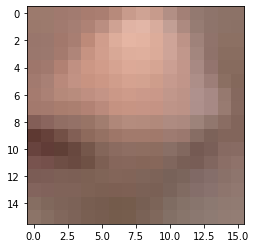

(80, 112)


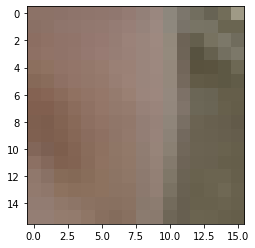

(80, 128)


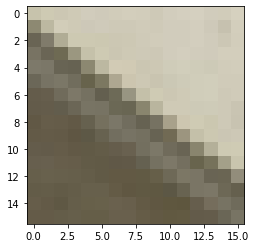

(80, 144)


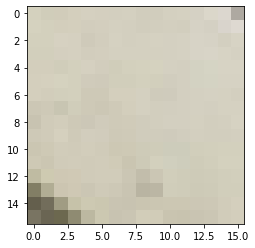

(80, 160)


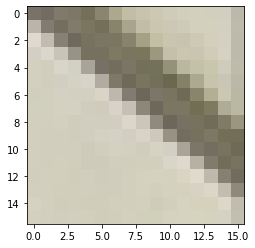

(96, 0)


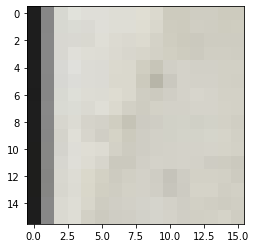

(96, 16)


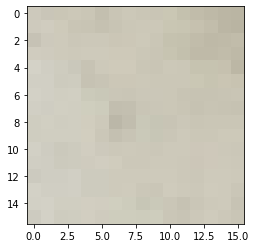

(96, 32)


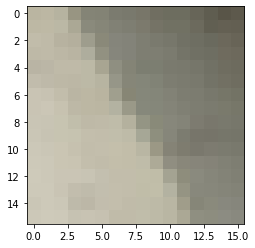

(96, 48)


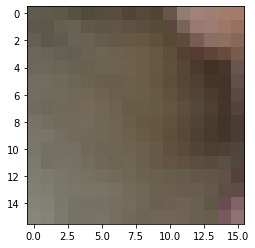

(96, 64)


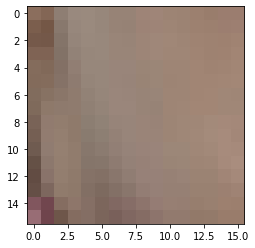

(96, 80)


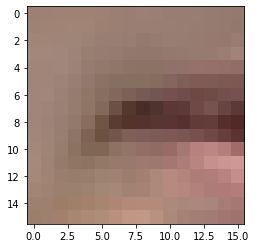

(96, 96)


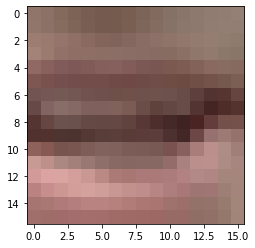

(96, 112)


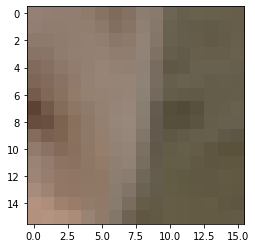

(96, 128)


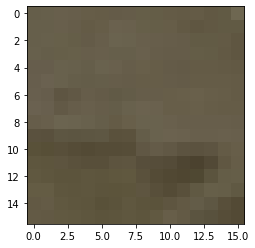

(96, 144)


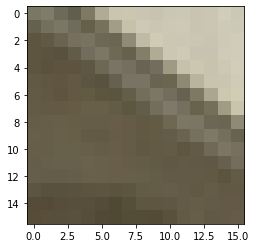

(96, 160)


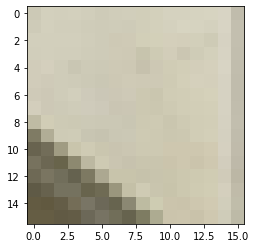

(112, 0)


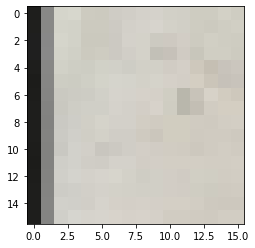

(112, 16)


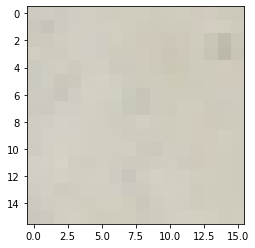

(112, 32)


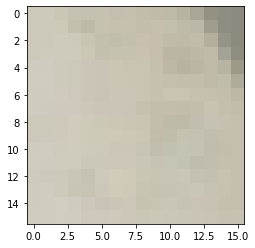

(112, 48)


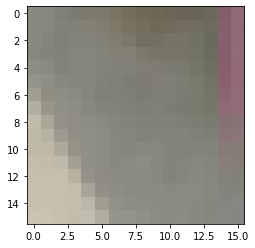

(112, 64)


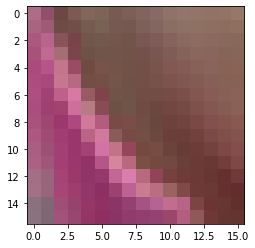

(112, 80)


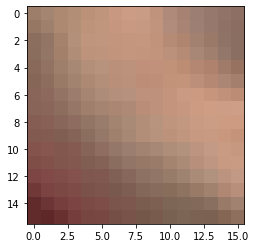

(112, 96)


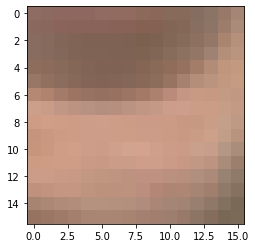

(112, 112)


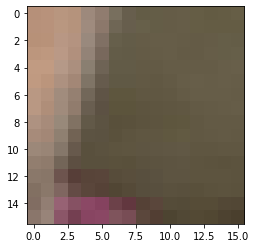

(112, 128)


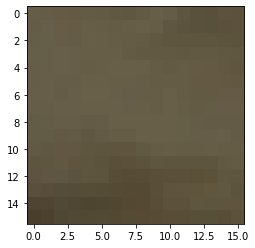

(112, 144)


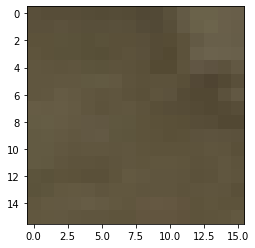

(112, 160)


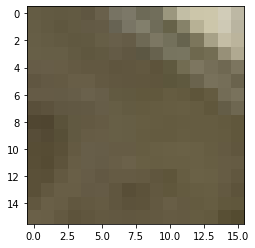

(128, 0)


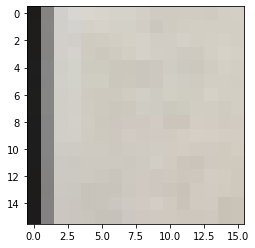

(128, 16)


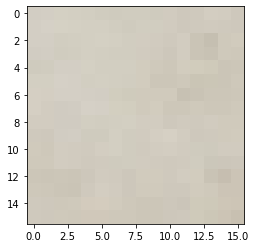

(128, 32)


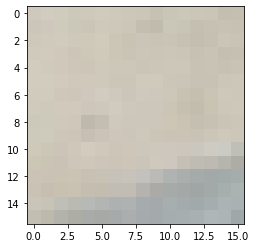

(128, 48)


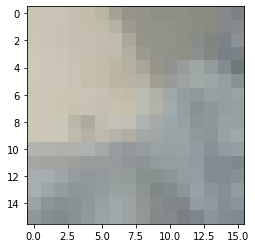

(128, 64)


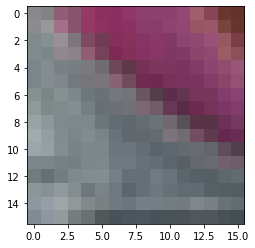

(128, 80)


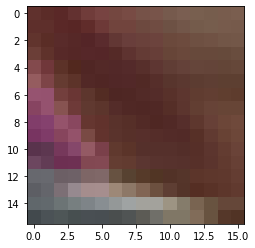

(128, 96)


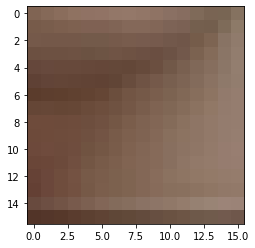

(128, 112)


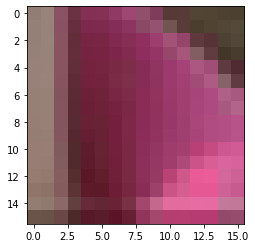

(128, 128)


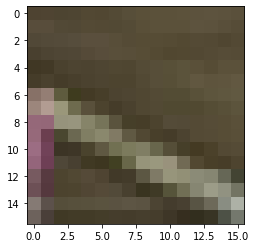

(128, 144)


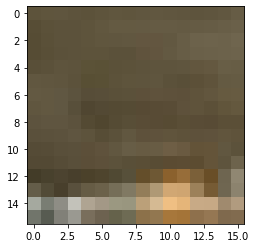

(128, 160)


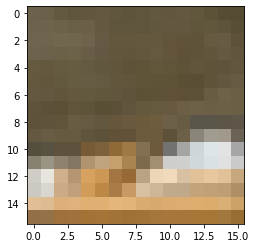

In [12]:
block_size = 16
blocks = get_blocks(frame, block_size)
for (block, coords) in blocks:
    plt.imshow(block)
    print(coords)
    plt.show()

In [13]:
frame.shape

(144, 176, 3)

In [14]:
def get_matching_block(mat: np.ndarray, block: np.ndarray, i0: int, j0: int, delta: int) -> np.ndarray:
    block_size = block.shape[0]
    
    start_i = max(0, i0 - delta // 2)
    stop_i = min(i0 + delta // 2, mat.shape[0] - block_size)
    
    start_j = max(0, j0 - delta // 2)
    stop_j = min(j0 + delta // 2, mat.shape[1] - block_size)
    
    min_err = float('inf')
    coords = None
    
    for i in range(start_i, stop_i):
        for j in range(start_j, stop_j):
            curr_block = mat[i : i + block_size, j : j + block_size, :]
            err = np.linalg.norm(block - curr_block)
            if err < min_err:
                min_err = err
                coords = (i, j)
    return coords

(48, 160)


(<matplotlib.image.AxesImage at 0x7f11d1994f50>, None)

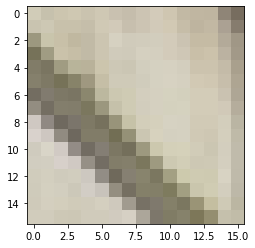

In [15]:
(block, coords) = blocks[43]
plt.imshow(block), print(coords)

In [16]:
delta = 10
mat = frames[0]
found_coords = get_matching_block(mat, block, coords[0], coords[1], delta)

In [17]:
found_block = mat[found_coords[0] : found_coords[0] + block_size, found_coords[1] : found_coords[1] + block_size, :]
#plt.imshow(found_block)

In [18]:
residual = block - found_block
#plt.imshow(residual)

In [19]:
def scale_to_img(array):
    array = array.astype(np.float32)
    vmin = array.min()
    array -= vmin
    vmax = array.max()
    array /= vmax
    array *= 255
    return array.astype(np.uint8), vmin, vmax

In [20]:
residuals = []
motion_vectors = []
for (block, coords) in blocks:
    found_coords = get_matching_block(mat, block, coords[0], coords[1], delta)
    found_block = mat[found_coords[0] : found_coords[0] + block_size,
                      found_coords[1] : found_coords[1] + block_size,
                      :]
    motion_vector = (coords[0] - found_coords[0], coords[1] - found_coords[1])
    residual = block.astype(np.float32) - found_block.astype(np.float32)
    residuals.append((residual, coords))
    motion_vectors.append(motion_vector)

In [21]:
residual = blocks_to_frame(residuals, height, width)

In [22]:
residual.min(), residual.max()

(0, 255)

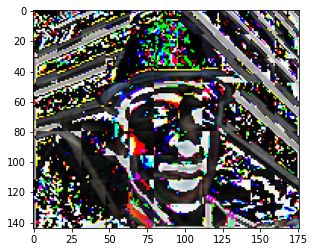

In [23]:
residual, vmin, vmax = scale_to_img(residual)
plt.imshow(residual)

In [24]:
#residuals -= residuals.min()

In [25]:
#residuals /= residuals.max()

In [26]:
#residuals *= 255
#residuals = residuals.astype(np.uint8)
#residuals

In [27]:
#plt.imshow(residuals), residuals.shape

In [48]:
def codedVector(motion_vector):
    code = bs.Bits(bin= '0b')
    for x in motion_vector:
      code += codeExpGolombExt(x)
    return code

def codeExpGolombExt(number):
  if number > 0:
    value = 2*number - 1
  else:
    value = -2*number
  size = int(np.log2(value+1)) + 1
  code = bs.Bits(bin= '0b0') * (size-1)
  code += bs.Bits(uint= value+1, length= size)
  return code

def readNumber(file_bits: bs.Bits):
  idx = 0
  size = 0
  value = bs.Bits(bin= '0b')

  b = file_bits[idx]

  while(not b):
      size += 1
      idx += 1
      b = file_bits[idx]
  
  for i in range(size+1):
    #print(idx, file_bits.len, size)
    b = file_bits[idx]
    value += bs.Bits(bin= '0b1') if b else bs.Bits(bin= '0b0')
    idx += 1

  value = value.uint - 1
  if value % 2 == 0:
    number = -1*value//2
  else:
    number = (value + 1)//2

  return file_bits[idx:], number

def writeVector(motion_vectors, video_bits):
  for v in motion_vectors:
    video_bits += codedVector(v)
  return video_bits

Códigos a seguir somente para testar as funções:


In [54]:
padding = 0
with open('vectors.em', 'wb') as f:
  bits = writeVector(motion_vectors, bs.Bits(bin= '0b'))
  padding = (8 - (bits.len % 8)) % 8
  bits.tofile(f)

In [53]:
bits = bs.Bits(filename= 'vectors.em')

if padding != 0:
  bits = bits[:-padding]

vector = []
num_blocks = 144//16 * 176//16

for i in range(num_blocks):
  bits, value1 = readNumber(bits)
  bits, value2 = readNumber(bits)
  vector.append((value1, value2))